In [48]:
import numpy as np
import scipy as sp
from scipy import signal
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

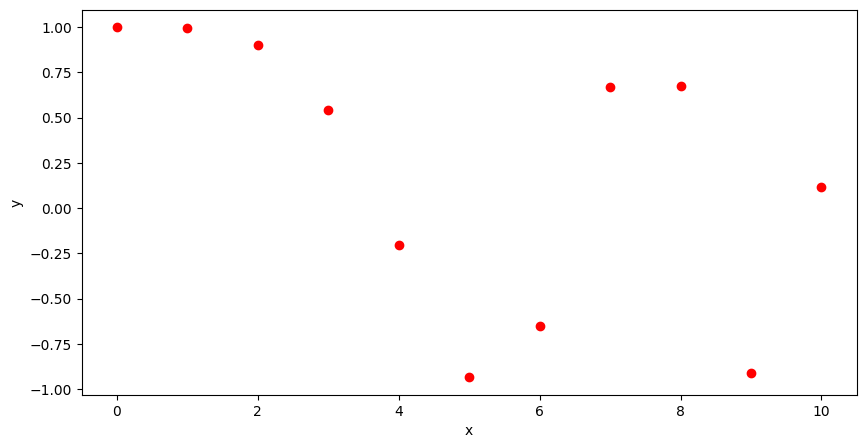

In [49]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)

plt.figure(figsize=(10,5))
plt.plot(x, y, 'ro')
plt.xlabel('x')
plt.ylabel('y');

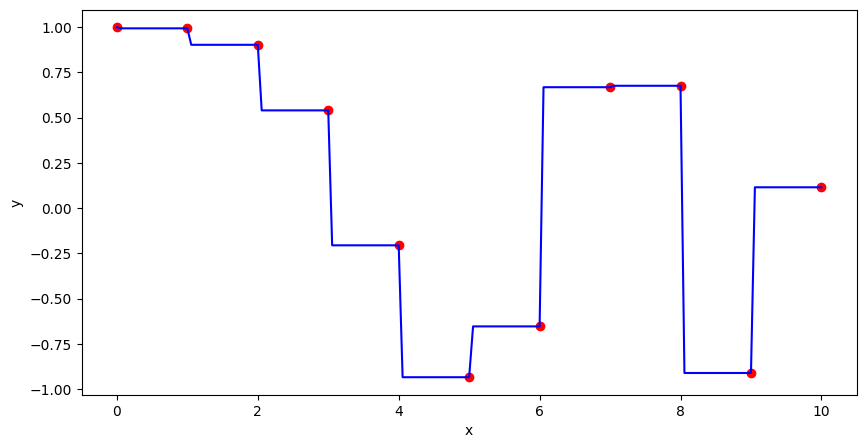

In [50]:
# try kind = 'cubic', 'nearest', 'next', 'previous', 'quadratic'
f = interp1d(x, y, kind='next')

xnew = np.linspace(0, 10, num=181, endpoint=True)

plt.figure(figsize=(10,5))
plt.plot(x, y, 'ro', xnew, f(xnew), '-b')
plt.xlabel('x')
plt.ylabel('y');

In [51]:
## Sampling in 2D

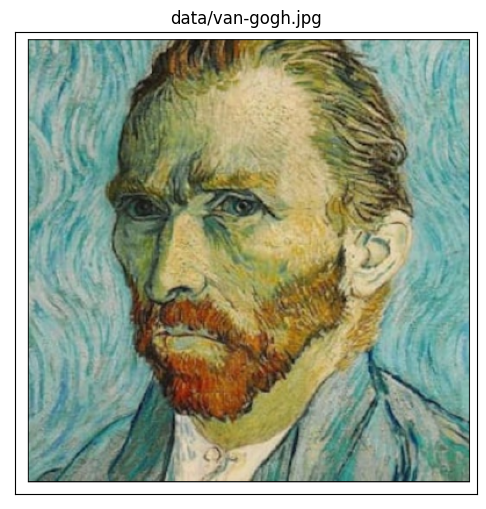

In [52]:
filename = 'data/van-gogh.jpg'
I = cv.imread(filename)
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.xticks([])
plt.yticks([])
plt.title('{}'.format(filename))
plt.imshow(I);

In [53]:
print('Shape = {}'.format(I.shape))
print('Data type = {}'.format(I.dtype))

Shape = (398, 398, 3)
Data type = uint8


In [54]:
# Setting up destination image
h, w = 32, 32
dst = np.empty((h, w, 3), dtype=I.dtype)

In [55]:
# Setting up sampling locations
# Now set up sampling coordinates. locs is setup to map (x,y) locations in the source image with corresponding pixel (i,j) locations in the destination image.
y_src = np.linspace(0, I.shape[0], h)
x_src = np.linspace(0, I.shape[1], w)
yy_src, xx_src = np.meshgrid(y_src, x_src)

y_dst = np.arange(0, h)
x_dst = np.arange(0, w)
yy_dst, xx_dst = np.meshgrid(y_dst, x_dst)

locs = zip(yy_src.flatten(), xx_src.flatten(), yy_dst.flatten().astype('uint'), xx_dst.flatten().astype('uint'))

In [56]:
# Performing sampling
# The following function copies pixel color at location (x,y) in the source image to pixel location (i,j) in the destination image.
def sample(I, dst, locs):
    for (y_src, x_src, y_dst, x_dst) in locs:
        s = (x_src, y_src) # Notice the switch of x and y
        dst[y_dst, x_dst] = cv.getRectSubPix(I, tuple((1,1)), tuple(s))[0,0]

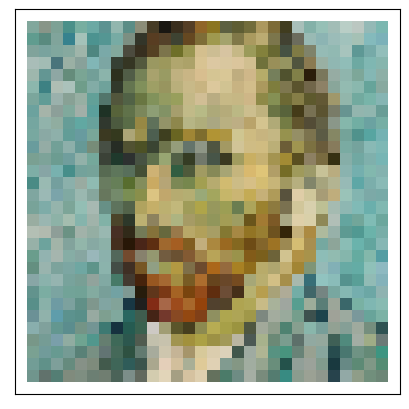

In [57]:
sample(I, dst, locs)
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(dst);

In [58]:
def setup_sampling_locs(I, dst, region=None, M=np.eye(3)):
    h, w = dst.shape[0], dst.shape[1]

    if region == None:
        y_src = np.linspace(0, I.shape[0], h)
        x_src = np.linspace(0, I.shape[1], w)
    else:
        y_src = np.linspace(region[0], region[1], h)
        x_src = np.linspace(region[2], region[3], w)
    yy_src, xx_src = np.meshgrid(y_src, x_src)
    
    pts_src = np.vstack((xx_src.flatten(), yy_src.flatten(), np.ones(h*w))) # Homogeneous coordinates 
    pts_transformed = np.dot(M, pts_src - np.mean(pts_src,1).reshape(3,1)) + np.mean(pts_src, 1).reshape((3,1))
    pts_transformed[0,:] = pts_transformed[0,:] / pts_transformed[2,:] # Homoegeneous divide
    pts_transformed[1,:] = pts_transformed[1,:] / pts_transformed[2,:]
    
    y_dst = np.arange(0, h)
    x_dst = np.arange(0, w)
    yy_dst, xx_dst = np.meshgrid(y_dst, x_dst)

    return lambda: zip(pts_transformed[1,:], pts_transformed[0,:], yy_dst.flatten().astype('uint'), xx_dst.flatten().astype('uint'))

In [59]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index 
       in 0, 1, ..., n-1 to a distinct RGB color. 
       The keyword argument name must be a standard 
       mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

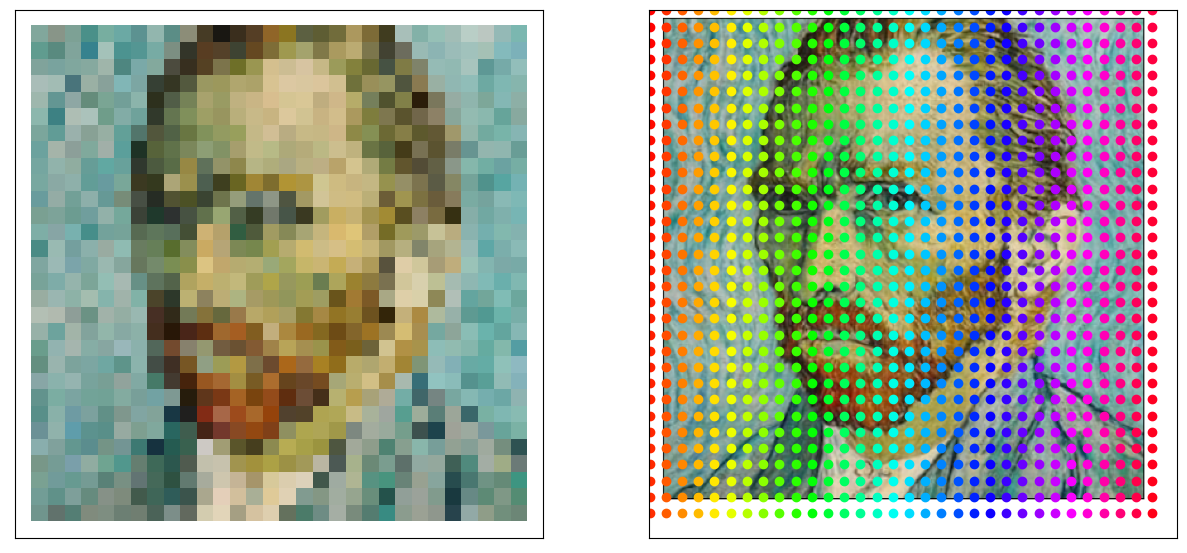

In [60]:
# Visualizing sampling locations
cmap = get_cmap(h*w)
locs = setup_sampling_locs(I, dst)
sample(I, dst, locs())
plt.figure(figsize=(15,7.5))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(dst)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(I)
for i, (y_src, x_src, _, _) in enumerate(locs()):
    plt.scatter(x_src, y_src, color=cmap(i))

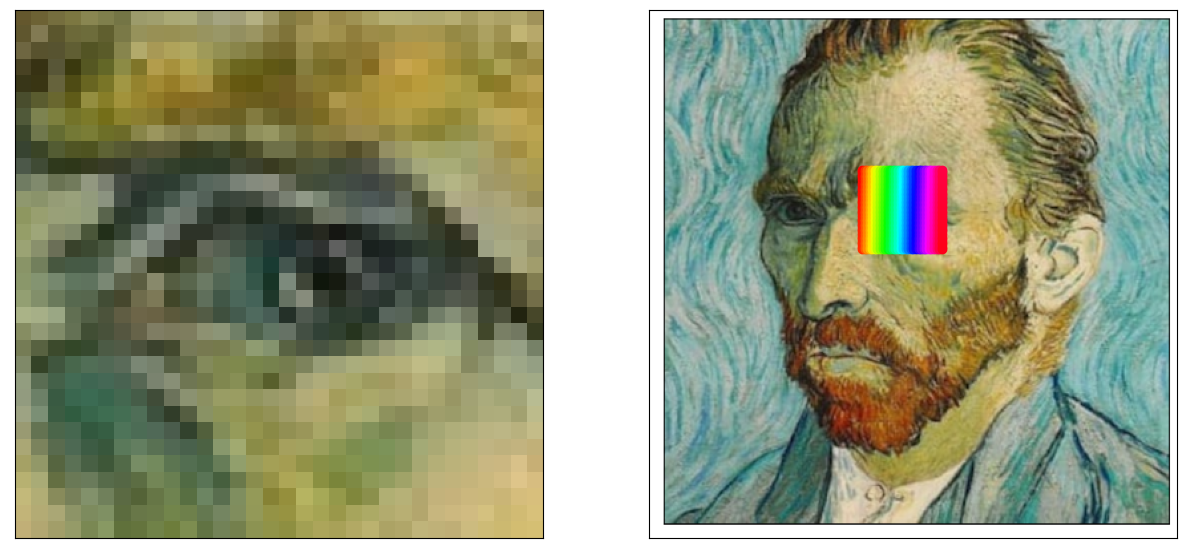

In [61]:
# Sampling over a subregion
cmap = get_cmap(h*w)
locs = setup_sampling_locs(I, dst, region=[120, 180, 160, 220])
sample(I, dst, locs())
plt.figure(figsize=(15,7.5))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(dst)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(I)
for i, (y_src, x_src, _, _) in enumerate(locs()):
    plt.scatter(x_src, y_src, color=cmap(i))

In [62]:
# Transforming the sampling locations (rotation, translation, scale)

In [63]:
def rot2d(theta_degrees):
    theta = np.pi * theta_degrees / 180.0
    r = np.eye(3)
    r[0][0] = np.cos(theta)
    r[0][1] = - np.sin(theta)
    r[1][0] = np.sin(theta)
    r[1][1] = np.cos(theta)
    return r

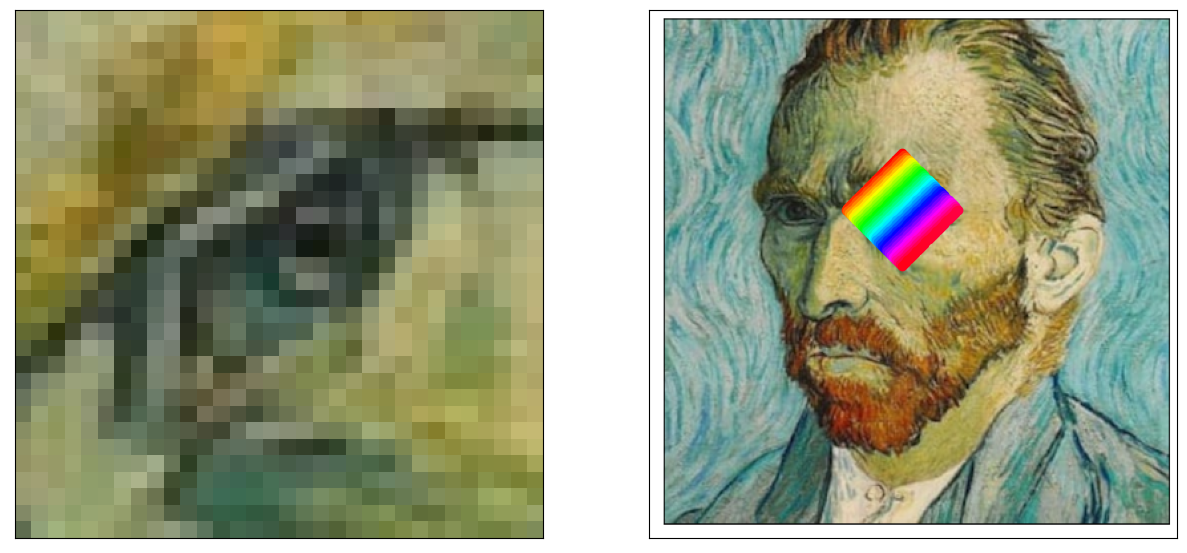

In [64]:
cmap = get_cmap(h*w)
locs = setup_sampling_locs(I, dst, region=[120, 180, 160, 220], M=rot2d(45))
sample(I, dst, locs())
plt.figure(figsize=(15,7.5))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(dst)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(I)
for i, (y_src, x_src, _, _) in enumerate(locs()):
    plt.scatter(x_src, y_src, color=cmap(i))

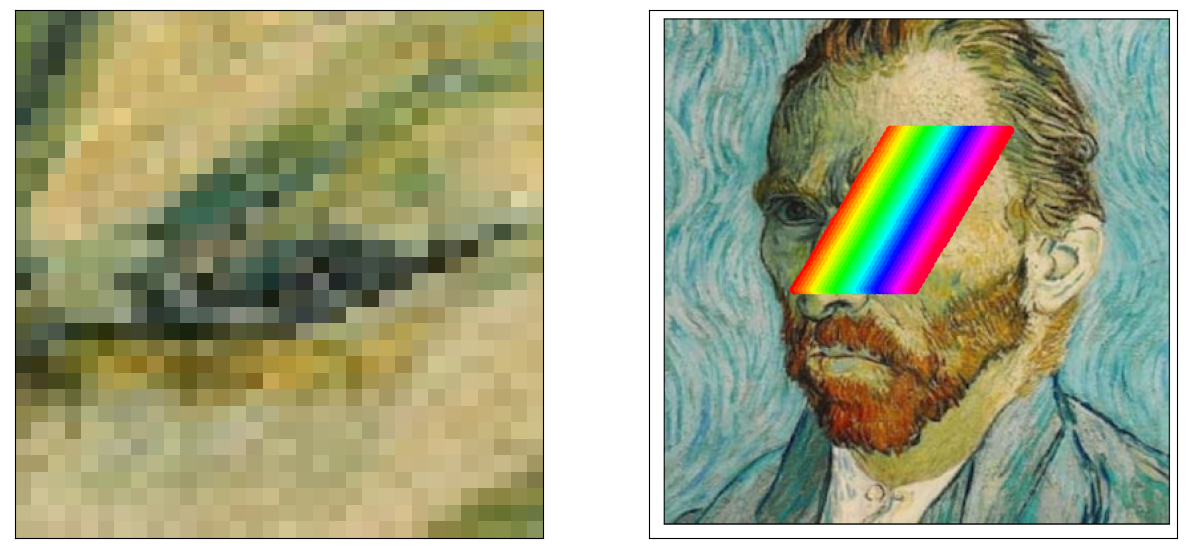

In [65]:
M = np.eye(3)
M[0,0] = 1.5
M[0,1] = .5
M[1,1] = -2
M[0,1] = 1.2

cmap = get_cmap(h*w)
locs = setup_sampling_locs(I, dst, region=[120, 180, 160, 220], M=M)
sample(I, dst, locs())
plt.figure(figsize=(15,7.5))
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.imshow(dst)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.imshow(I)
for i, (y_src, x_src, _, _) in enumerate(locs()):
    plt.scatter(x_src, y_src, color=cmap(i))